<a href="https://colab.research.google.com/github/nkumeh/MusicInformationRetrieval/blob/main/bird_call_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import and Load Dependencies and Libraries

In [2]:
# !pip install tensorflow_io
# !pip install tensorflow==2.8
# !pip install tensorflow-io==0.23.1


In [3]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio

### Build Data Loading Function

In [4]:
# data loading function from tensorflow documentation

def load_wav_16k_mono(filename):
    # load the encoded wav file and convert to waveform
    file_content = tf.io.read_file(filename) # this return a string not the audio yet

    # decode wav (tensors by channels)
    wav, sr = tf.audio.decode_wav(file_content, desired_channels=1) # mono channel not stereo for ease of analysis

    # remove trailing axis sr--> 44100HZ
    wav = tf.squeeze(wav, axis=-1)
    sr = tf.cast(sr, dtype = tf.int64)

    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)

    return wav

In [5]:
path_to_file_or_directory = "/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/"

In [6]:
path_to_file_or_directory

'/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/'

In [7]:
# Defining paths to files and Plot

CAPUCHIN_FILE = path_to_file_or_directory + 'Parsed_Capuchinbird_Clips/XC3776-0.wav'
NOT_CAPUCHIN_FILE = path_to_file_or_directory + 'Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

In [8]:
CAPUCHIN_FILE

'/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/Parsed_Capuchinbird_Clips/XC3776-0.wav'

In [9]:
CAPUCHIN_FILE

'/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/Parsed_Capuchinbird_Clips/XC3776-0.wav'

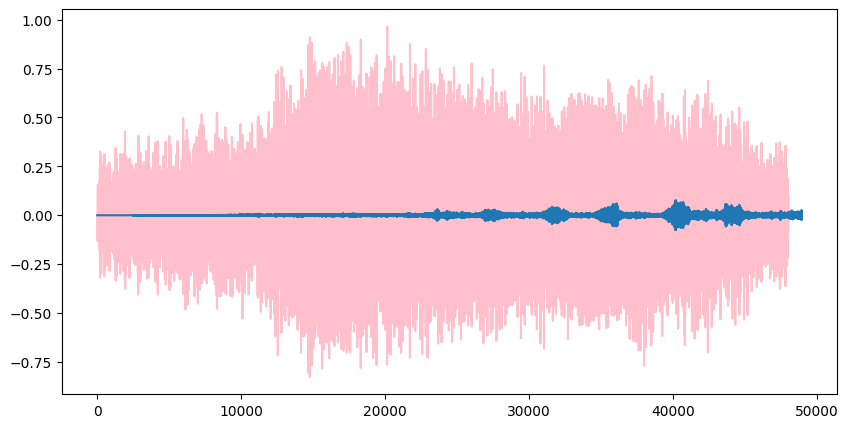

In [10]:
plt.figure(figsize=(10,5))
plt.plot(wave, color="pink")
plt.plot(nwave)
plt.show()

### Create Tensorflow Dataset

In [11]:
# define global variables for posirive and negative data paths

POS = path_to_file_or_directory + 'Parsed_Capuchinbird_Clips'
NEG = path_to_file_or_directory + 'Parsed_Not_Capuchinbird_Clips'

In [12]:
POS
NEG


'/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/Parsed_Not_Capuchinbird_Clips'

In [13]:
# set of files as a string in tensorflow
# look for files in the .wav format
pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*.wav')

In [14]:
pos.as_numpy_iterator().next()

b'/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/Parsed_Capuchinbird_Clips/XC600460-2.wav'

In [15]:
# add labels and combine pos and negative values
# adding same length of 1s for pos 0s for neg .... binary classification problem

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

# concatenate
data = positives.concatenate(negatives)

In [16]:
data.shuffle(900).as_numpy_iterator().next()

(b'/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/Parsed_Capuchinbird_Clips/XC46077-2.wav',
 1.0)

### Determine Average Length of Capuchin Call

In [17]:
# calculate wave cycle length

lengths = []

# were using positive calls cuz we want the calls that
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
    # go through list of pos and apply
    lengths.append(len(tensor_wave))

In [18]:
os.listdir(NEG)

['Crickets-chirping-10.wav',
 'Crickets-chirping-1.wav',
 'Crickets-chirping-0.wav',
 'Crickets-chirping-3.wav',
 'Crickets-chirping-2.wav',
 'Crickets-chirping-4.wav',
 'Crickets-chirping-5.wav',
 'Crickets-chirping-at-night-11.wav',
 'Crickets-chirping-8.wav',
 'Crickets-chirping-at-night-1.wav',
 'Crickets-chirping-at-night-10.wav',
 'Crickets-chirping-7.wav',
 'Crickets-chirping-at-night-0.wav',
 'Crickets-chirping-9.wav',
 'Crickets-chirping-6.wav',
 'Crickets-chirping-at-night-13.wav',
 'Crickets-chirping-at-night-2.wav',
 'Crickets-chirping-at-night-3.wav',
 'Crickets-chirping-at-night-4.wav',
 'Crickets-chirping-at-night-12.wav',
 'Crickets-chirping-at-night-5.wav',
 'afternoon-birds-song-in-forest-0.wav',
 'afternoon-birds-song-in-forest-11.wav',
 'afternoon-birds-song-in-forest-1.wav',
 'afternoon-birds-song-in-forest-12.wav',
 'afternoon-birds-song-in-forest-10.wav',
 'Crickets-chirping-at-night-8.wav',
 'Crickets-chirping-at-night-6.wav',
 'Crickets-chirping-at-night-9.wav'

### Let's get some Stats of the Capuchin Calls!

In [19]:
54156/16000 #capuchin calls per sec

3.38475

In [20]:
tf.math.reduce_mean(lengths)


<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [21]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [22]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

### Preprocessing and Convertion to Spectrogram: Short Term Fourier Transform

In [23]:
# label used for forward / backward as part of the data pipeline, output at the end

def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]

    # for the clips that < 48000, we pad with zeros at the beginning(start)
    zero_padding_space = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding_space, wav], 0)

    # using the short term FT to convert to spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)

    # encapsulate spectrogram in appropriate dimentinality format for conv neral network, since it requires a channels dimention
    # liken to greyscale image in single channel
    spectrogram = tf.expand_dims(spectrogram, axis = 2)

    return spectrogram, label

In [24]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)
wav
wav = wav[:48000]

    # for the clips that < 48000, we pad with zeros at the beginning(start)
zero_padding_space = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding_space, wav], 0)

wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 1.0432389e-06, -3.0215922e-06,  1.9820709e-06, ...,
       -4.5542806e-02, -5.4887902e-02, -8.5778177e-02], dtype=float32)>

In [25]:
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram)

# encapsulate spectrogram in appropriate format
spectrogram = tf.expand_dims(spectrogram, axis = 2)
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[1.9284576e-02],
        [2.5178067e-02],
        [2.9214473e-02],
        ...,
        [3.1451735e-04],
        [2.5453046e-04],
        [4.2855740e-05]],

       [[9.8426342e-03],
        [6.1191549e-03],
        [8.5132420e-03],
        ...,
        [4.6083337e-04],
        [2.3399896e-04],
        [2.1843612e-04]],

       [[1.1091478e-02],
        [6.1595612e-03],
        [8.8293683e-03],
        ...,
        [5.1367306e-04],
        [3.0327094e-04],
        [2.1337718e-04]],

       ...,

       [[6.3687041e-03],
        [7.4077337e-03],
        [1.7366953e-02],
        ...,
        [5.8575958e-04],
        [2.5817397e-04],
        [1.5325844e-05]],

       [[5.7284534e-03],
        [1.0320810e-02],
        [9.9355401e-03],
        ...,
        [6.0393481e-04],
        [2.4145524e-04],
        [8.3535910e-05]],

       [[4.4908077e-03],
        [4.3124957e-03],
        [1.3786455e-02],
        ...,
        [5.7142752

### Test out Function and Visualise Spectrogram

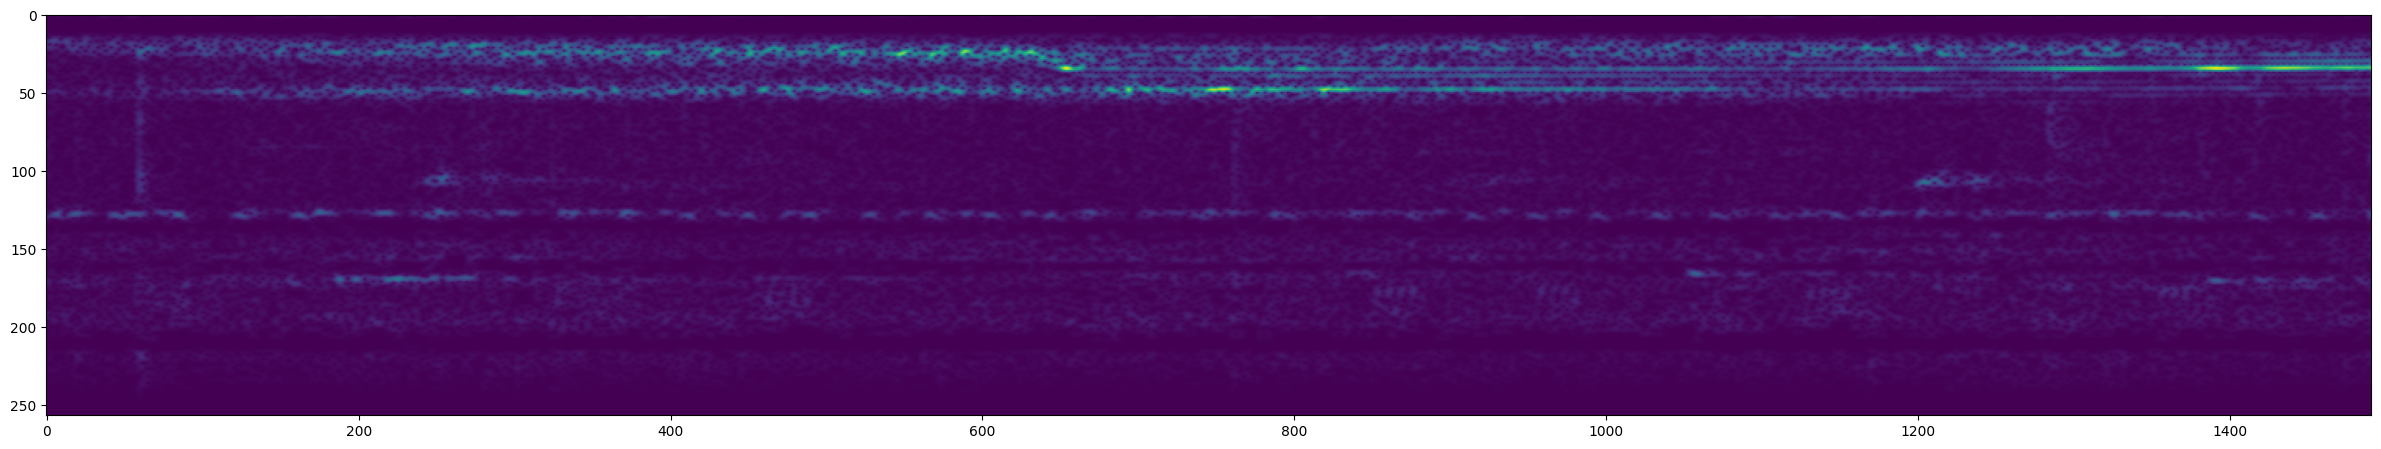

In [26]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

plt.figure(figsize=(30,10))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [27]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[1.4572836e-02],
        [1.4680829e-02],
        [1.7477216e-02],
        ...,
        [8.3052852e-05],
        [6.7998721e-05],
        [1.7605722e-05]],

       [[2.4989322e-02],
        [2.5006097e-02],
        [1.7421925e-02],
        ...,
        [8.6744782e-05],
        [6.4170068e-05],
        [2.9578805e-05]],

       [[3.9181456e-02],
        [3.3696018e-02],
        [1.8238828e-02],
        ...,
        [1.1119853e-04],
        [6.4556400e-05],
        [4.0873885e-05]],

       ...,

       [[2.6167430e-02],
        [2.6340272e-02],
        [2.0124378e-02],
        ...,
        [2.5325693e-04],
        [9.1971495e-05],
        [9.8489225e-05]],

       [[1.1437938e-02],
        [1.8734852e-02],
        [1.7960491e-02],
        ...,
        [2.2450027e-04],
        [6.5675835e-05],
        [1.1189282e-04]],

       [[3.3173859e-03],
        [1.5963564e-02],
        [1.6169842e-02],
        ...,
        [1.5651138

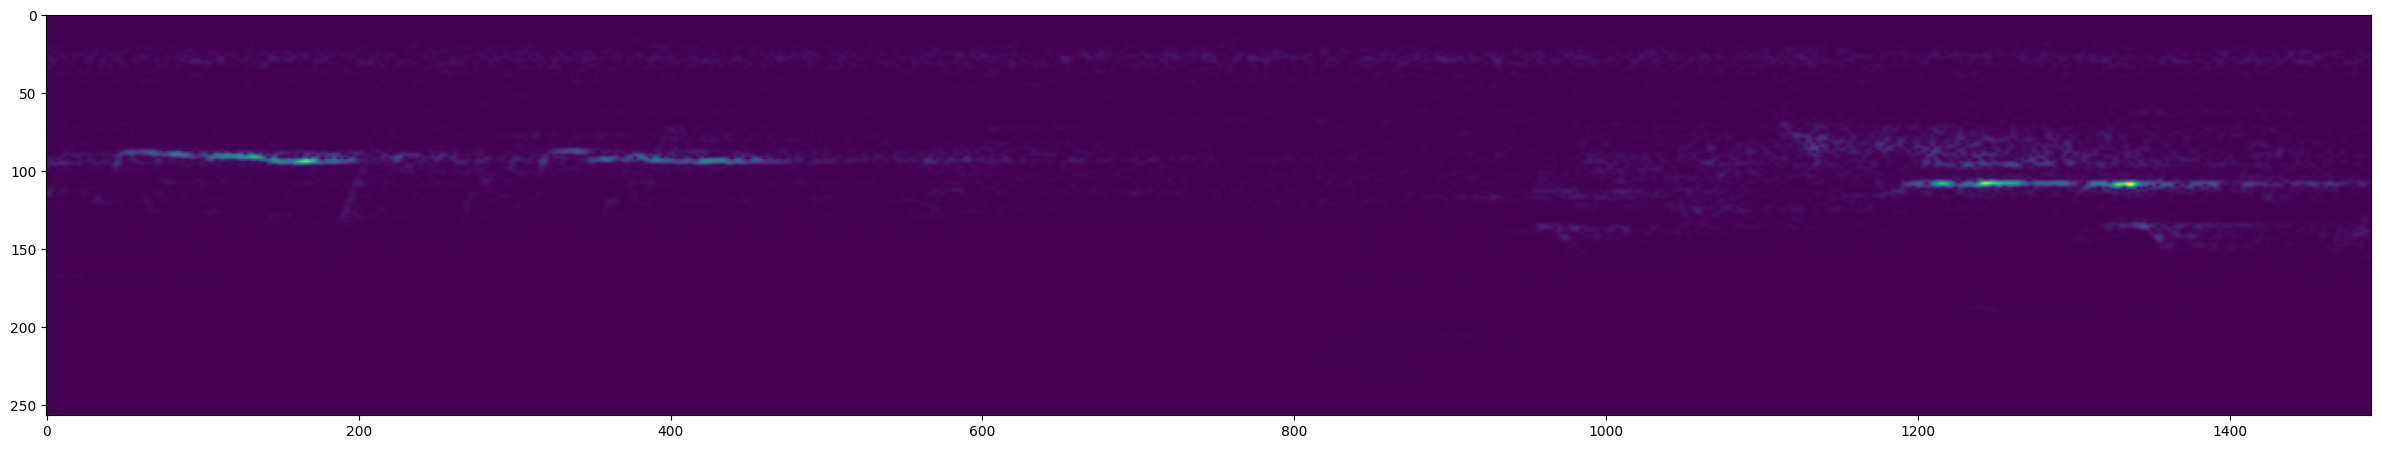

In [28]:
filepath_n, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram_n, label = preprocess(filepath_n, label)
plt.figure(figsize=(30,10))
plt.imshow(tf.transpose(spectrogram_n)[0])
plt.show()

### Create a Train and Test Partition

In [29]:
# MCSHUBAP
data = data.map(preprocess)
data = data.cache()
# shuffling to decrease overfitting / bias
data = data.shuffle(buffer_size=1000)
# smaples to take at a time
data = data.batch(16)
# eliminates any cpu bottlenecking
data = data.prefetch(8)

In [30]:
len(data)*.7
# round up and take 36

35.699999999999996

In [31]:
len(data)*.3

15.299999999999999

In [32]:
# split into test and train

train = data.take(36)
test = data.skip(36).take(15)

In [33]:
samp, label = test.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [34]:
samp.shape
# shape is foundation for input into model

(16, 1491, 257, 1)

In [35]:
label.shape

(16,)

### Build Deep Learning Model

In [36]:
# model apis
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

In [37]:
# build sequencial model -- ran into memory issues without using Max pooling, addded those layers
# after several sessions crashed

model = Sequential()
# input shape is tied to the shape of the spectrogram
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 744, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 371, 62, 16)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 368032)            0         
                                                                 
 dense (Dense)               (None, 128)               4

### Fit Model, View Loss and KPI Plots

In [40]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 121s 3s/step - loss: 0.5033 - recall: 0.8917 - precision: 0.8284 - val_loss: 0.0649 - val_recall: 1.0000 - val_precision: 0.9688
Epoch 2/4
36/36 [==============================] - 120s 3s/step - loss: 0.0669 - recall: 0.9689 - precision: 0.9750 - val_loss: 0.0142 - val_recall: 0.9831 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 120s 3s/step - loss: 0.0087 - recall: 0.9876 - precision: 1.0000 - val_loss: 0.0198 - val_recall: 0.9714 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 120s 3s/step - loss: 0.0071 - recall: 0.9934 - precision: 0.9934 - val_loss: 4.2440e-04 - val_recall: 1.0000 - val_precision: 1.0000


In [41]:
# keeps a dictionary stats for loss, precision and recall per epoch
hist.history

{'loss': [0.503296971321106,
  0.06693624705076218,
  0.008714351803064346,
  0.007081976160407066],
 'recall': [0.8917197585105896,
  0.9689440727233887,
  0.9875776171684265,
  0.9934210777282715],
 'precision': [0.8284023404121399,
  0.9750000238418579,
  1.0,
  0.9934210777282715],
 'val_loss': [0.06493295729160309,
  0.014154945500195026,
  0.019775768741965294,
  0.000424403726356104],
 'val_recall': [1.0, 0.9830508232116699, 0.9714285731315613, 1.0],
 'val_precision': [0.96875, 1.0, 1.0, 1.0]}

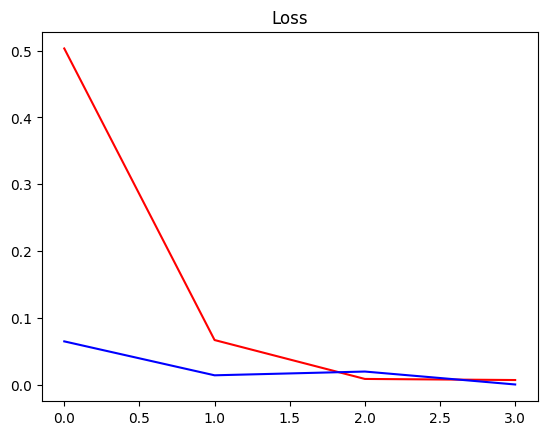

In [42]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

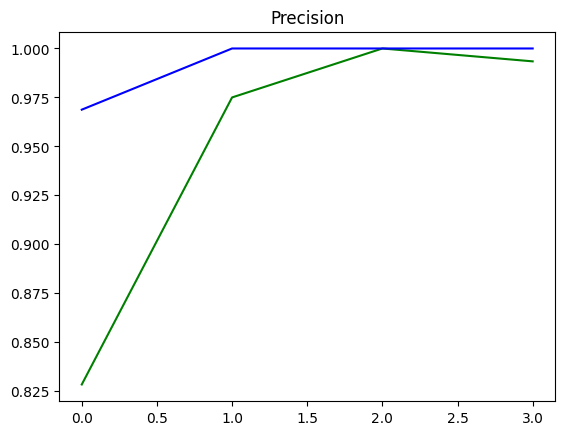

In [43]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'g')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

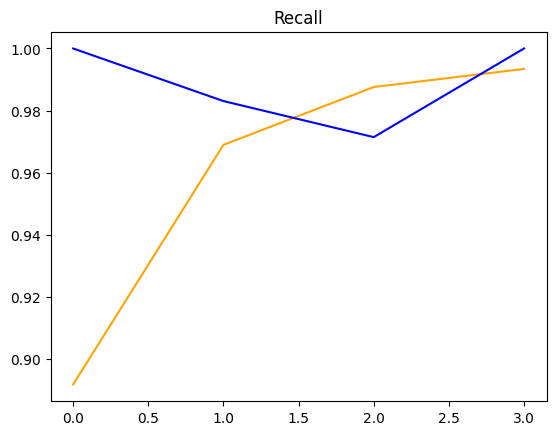

In [44]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'orange')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# **Make a Prediction on a Single Clip**

In [45]:
X_test, y_test = test.as_numpy_iterator().next()

In [46]:
# x_test os the spectrogram
X_test.shape

(16, 1491, 257, 1)

In [54]:
# number of labels
y_test.shape

(16,)

In [55]:
# pass x_test through model and make predictions --> yhat
yhat = model.predict(X_test)

In [56]:
# confidence metrics ---> if > 50% then 1 if not 0 --> 50% confidence
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [57]:
yhat

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0]

In [59]:
# how many capuchins in clip -- > number of 1s
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [60]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [61]:
# accurate prediction observed y_test == yhat
y_test.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0])

# **Build Forest Parsing Functions**

In [62]:
# Load up MP3s

def load_mp3_16k_mono(filename):
    # load the encoded wav file and convert to waveform
    res = tfio.audio.AudioIOTensor(filename)

    # convert mp3 file to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2

    # extract smaole rate and cast
    sr = res.rate
    sr = tf.cast(sr,dtype=tf.int64)

    # resample to 16kHz
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(tensor, rate_in=sr, rate_out=16000)

    return wav


In [147]:
mp3 = path_to_file_or_directory + 'ForestRecordings/recording_08.mp3'

In [148]:
mp3

'/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/ForestRecordings/recording_08.mp3'

In [149]:
ipd.Audio(mp3)

In [85]:
wav = load_mp3_16k_mono(mp3)

In [86]:
wav

<tf.Tensor: shape=(2880666,), dtype=float32, numpy=
array([ 8.1433272e-12, -5.7019250e-12, -5.3486417e-12, ...,
       -1.1291276e-02, -1.4230422e-02, -3.0555837e-03], dtype=float32)>

In [87]:
# we need to get slices of the longer clip to pass it through out model
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [88]:
samples, index = audio_slices.as_numpy_iterator().next()

In [89]:
index

array([8.143327e-12], dtype=float32)

In [90]:
samples.shape

(1, 48000)

In [91]:
# 60 windows that we want to convert to spectrograms
len(audio_slices)

60

## **Build Function to Convert Clips into Windowed Spectrograms**

In [92]:
def preprocess_mp3(sample, index):
  sample = sample[0]

  # for the clips that < 48000, we pad with zeros at the beginning(start)
  zero_padding_space = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
  wav = tf.concat([zero_padding_space, sample], 0)

  # using the short term FT to convert to spectrogram
  spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
  spectrogram = tf.abs(spectrogram)

  # encapsulate spectrogram in appropriate dimentinality format for conv neral network, since it requires a channels dimention
  # liken to greyscale image in single channel
  spectrogram = tf.expand_dims(spectrogram, axis = 2)

  return spectrogram

In [93]:
# convery longer audio clips into windowed spectograms and make parse through our model for predictions

audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,  wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)


In [117]:
# bump up prediction confidence to 99%
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

In [118]:
yhat

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [119]:
# same length
len(yhat)

60

In [120]:
from itertools import groupby

In [121]:
yhat = [key for key, group in groupby(yhat)]

In [122]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [123]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [124]:
calls = tf.math.reduce_sum(yhat).numpy()

In [126]:
# consecutive 1s and 0s are grouped as 1 to give number of calls in clip
calls

5

# **Make Predictions**

In [127]:
os.listdir(path_to_file_or_directory + 'ForestRecordings')

['recording_00.mp3',
 'recording_01.mp3',
 'recording_02.mp3',
 'recording_03.mp3',
 'recording_04.mp3',
 'recording_05.mp3',
 'recording_06.mp3',
 'recording_07.mp3',
 'recording_08.mp3',
 'recording_09.mp3',
 'recording_10.mp3',
 'recording_11.mp3',
 'recording_12.mp3',
 'recording_14.mp3',
 'recording_13.mp3',
 'recording_15.mp3',
 'recording_16.mp3',
 'recording_17.mp3',
 'recording_18.mp3',
 'recording_19.mp3',
 'recording_20.mp3',
 'recording_21.mp3',
 'recording_22.mp3',
 'recording_23.mp3',
 'recording_26.mp3',
 'recording_25.mp3',
 'recording_24.mp3',
 'recording_27.mp3',
 'recording_29.mp3',
 'recording_28.mp3',
 'recording_31.mp3',
 'recording_30.mp3',
 'recording_32.mp3',
 'recording_34.mp3',
 'recording_35.mp3',
 'recording_33.mp3',
 'recording_36.mp3',
 'recording_38.mp3',
 'recording_37.mp3',
 'recording_40.mp3',
 'recording_42.mp3',
 'recording_39.mp3',
 'recording_41.mp3',
 'recording_43.mp3',
 'recording_44.mp3',
 'recording_46.mp3',
 'recording_45.mp3',
 'recording_4

In [ ]:
# FILEPATH = os.path.join(path_to_file_or_directory + 'ForestRecordings', "xyz")
# FILEPATH
os.listdir(path_to_file_or_directory + 'ForestRecordings')

In [142]:
# Loop over recording and make predictions

results = {}

for mp3_file in os.listdir(path_to_file_or_directory + 'ForestRecordings'):
  FILEPATH = path_to_file_or_directory + 'ForestRecordings/' + mp3_file

  # load
  wav = load_mp3_16k_mono(FILEPATH)
  # convert
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav,  wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
  # preprocess to spec
  audio_slices = audio_slices.map(preprocess_mp3)
  # batch it up
  audio_slices = audio_slices.batch(64)

  yhat = model.predict(audio_slices)

  results[mp3_file] = yhat


In [143]:
results

{'recording_00.mp3': array([[1.5577674e-03],
        [3.8394332e-04],
        [1.0633469e-03],
        [8.1195253e-01],
        [1.0000000e+00],
        [4.3666363e-03],
        [3.6656857e-04],
        [8.9588761e-04],
        [3.4880638e-04],
        [1.4740229e-03],
        [5.4541230e-04],
        [4.3401122e-04],
        [5.3706765e-04],
        [9.9996018e-01],
        [1.0000000e+00],
        [2.8839707e-04],
        [9.9612627e-08],
        [3.3000112e-04],
        [8.0031157e-04],
        [1.3164580e-03],
        [8.7645650e-04],
        [3.4463406e-04],
        [1.2621880e-03],
        [4.3711841e-01],
        [1.0000000e+00],
        [7.9409182e-03],
        [6.9432317e-05],
        [1.2706518e-03],
        [8.4683299e-04],
        [1.4045537e-03],
        [4.7600269e-04],
        [1.4739931e-03],
        [4.1577220e-03],
        [5.0091743e-04],
        [2.6429594e-03],
        [3.2763481e-03],
        [1.0000000e+00],
        [5.8800232e-01],
        [1.0319352e-03],
     

In [144]:
class_preds = {}

for file, logits in results.items():
  class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [156]:
postprocessed = {}

for file, scores in class_preds.items():
  postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 22,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_14.mp3': 0,
 'recording_13.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 3,
 'recording_18.mp3': 2,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_26.mp3': 2,
 'recording_25.mp3': 15,
 'recording_24.mp3': 0,
 'recording_27.mp3': 0,
 'recording_29.mp3': 0,
 'recording_28.mp3': 15,
 'recording_31.mp3': 1,
 'recording_30.mp3': 3,
 'recording_32.mp3': 2,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_33.mp3': 0,
 'recording_36.mp3': 0,
 'recording_38.mp3': 1,
 'recording_37.mp3': 3,
 'recording_40.mp3': 1,
 'recording_42.mp3': 0,
 'recording_3

# **Export Data**

In [150]:
import csv

In [158]:
with open('/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/capuchin_bird_results.csv', 'w', newline='') as f:
  writer = csv.writer(f, delimiter=',')
  writer.writerow(['recordings', 'capuchin_calls'])

  for key, value in postprocessed.items():
    writer.writerow([key, value])


In [ ]:
# rec_1 = '/content/drive/MyDrive/AudioSignalProcessing/DeepLearningTrials/audio_classification/data/Forest Recordings/recording_00.mp3'
# ipd.Audio(rec_1)
# rec, sr = librosa.load(rec_1)
# librosa.display.waveshow(rec, alpha=0.5)